# Exploratory analysis | Fake News Dataset

## Big Data

This notebook is the first in the series of this project and it contains the exploratory analysis of our training and test sets of our fake news detection dataset. We have tried to conduct as many aggregations as possible given the few columns in our datasets. The outline of this notebook is as follows: 
- Loading the pre-requisites
- Loading the data
- Exploratory analysis
    - NA values
    - Distribution of the target counts
- Relationship between features extracted and the target 
- Preprocessing data
- Word clouds

**Kernel : Python 3**

### Loading pre-requisites

In [29]:
!pip install wordcloud
!pip install -U seaborn
!pip install nltk
!pip install wordcloud


Requirement already up-to-date: seaborn in c:\users\ankit\appdata\local\continuum\anaconda3\lib\site-packages (0.11.1)


In [1]:
#  General 
import numpy as np
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

# Data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Loading the data

In [30]:
train_df = pd.read_csv("train.csv") 
test_df = pd.read_csv("test.csv") 
print(train_df.shape, test_df.shape)

(20800, 5) (5200, 4)


In [4]:
print(train_df.dtypes)
print(test_df.dtypes)
train_df.text = train_df.text.astype(str)
train_df.title = train_df.text.astype(str)
test_df.text = test_df.text.astype(str)
test_df.title = test_df.text.astype(str)

id         int64
title     object
author    object
text      object
label      int64
dtype: object
id         int64
title     object
author    object
text      object
dtype: object


In [5]:
# Preview the first 5 lines of the loaded data 
train_df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,Ever get the feeling your life circles the rou...,Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,Videos 15 Civilians Killed In Single US Airstr...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Print \nAn Iranian woman has been sentenced to...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
test_df.head(5)

,id,title,author,text
0,20800,"PALO ALTO, Calif. — After years of scorning...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,Videos #NoDAPL: Native American Leaders Vow to...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"If at first you don’t succeed, try a different...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


## Exploratory analysis
- Replacing NA values

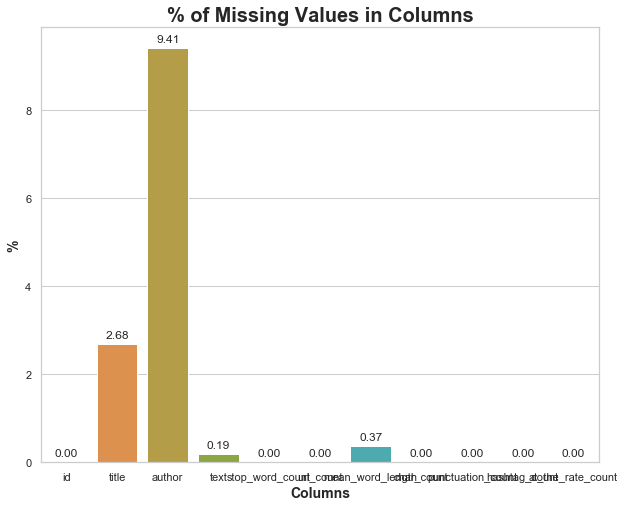

In [34]:
# Visualising the missing values % for the training set
missing_values = dict(zip([col for col in train_df.columns if col != "label"],
                          [round(100*train_df[col].isnull().sum()/len(train_df), 2) for col in train_df.columns
                           if col != "label"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("% of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("%", size=14, weight="bold")
plt.show()

In [8]:
print(train_df.isnull().sum()) 
print(test_df.isnull().sum())

id           0
title        0
author    1957
text         0
label        0
dtype: int64
id          0
title       0
author    503
text        0
dtype: int64


In [9]:
train_df = train_df.fillna("Missing")
test_df = test_df.fillna("Missing")

- Distribution of the  target variable

The target variable is  evenly distributed meaning our dataset is balanced

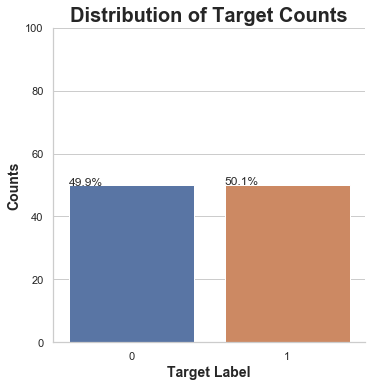

In [10]:
freq = pd.DataFrame(train_df['label'].value_counts(normalize=True) * 100)
freq.columns = ["percent"]
freq['label'] = freq.index

g = sns.catplot(x = "label", y="percent",  kind='bar', data = freq)
g.ax.set_ylim(0,100)
for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)
plt.title("Distribution of Target Counts", size=20, weight="bold")
plt.xlabel("Target Label", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()


## Relationship between features extracted and the target 
### Author and title
The idea is to find the features of the title and author in order to make hypotheses on how to identify fake news. 
* Correlation between the length (in words) of title and the label : 
    - We find that the titles for the true news are longer
* Correlation between the length (in words) of the author and the label :
    - The character counts for authors are longer because they can be some long links or email ids as sources. The difference in length is striking.

In [39]:
train_df["title count"] = train_df['title'].str.split().str.len()
train_df["author count"] = train_df['author'].str.split().str.len()
train_df["text count"] = train_df['text'].str.split().str.len()

In [37]:
test_df["title count"] = test_df['title'].str.split().str.len()
test_df["author count"] = test_df['author'].str.split().str.len()
test_df["text count"] = test_df['text'].str.split().str.len()

Text(0.5, 1.0, 'Distribution of title count across fake and real news')

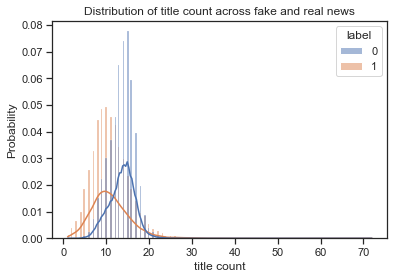

In [53]:
sns.histplot(data=train_df, x="title count",stat="probability", hue="label", kde=True)
plt.title("Distribution of title word count across fake and real news")

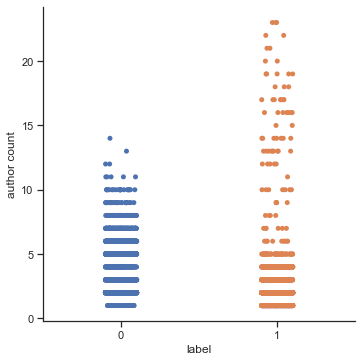

In [49]:
sns.set_theme(style="ticks", color_codes=True)
sns.catplot(x="label", y="author count", data = train_df)
plt.title("Distribution of author character count across fake and real news")

### Dissecting the text

Here we have conducted the analysis for the following features
- Number of stop words
- URLs
- Number of punctuations
- Number of characters
- Number of hashtags

on two levels
1. distribution of the target in the training set
2. training v/s test sets 


**Findings**
Let us take the analysis of the text in the training set feature by feature
- Text character count 
    - Fake news have less voluminous texts
- Stop word count
    - Higher for fake news
- URL count
    - Very high for fake news
    - Negligible for real news
- Hashtags and @ signs
    - Very high for fake news
    - Negligible for real news
    
We find that the occurence of each of the features is lower in the test set as it is smaller in size. No outliers are found i.e., all features are greater in frequency in the training set as it should be. 

It is tricky to say that this is a biased because on the one hand there is a clear cut implication of fakenews having special characters and weird authors but then again if we look at the word clouds, our dataset is very US centric. Other countries might have different conventions in labelling fake news. 

In [33]:
# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# @ count
train_df['at_the_rate_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['at_the_rate_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


C:\Users\ankit\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


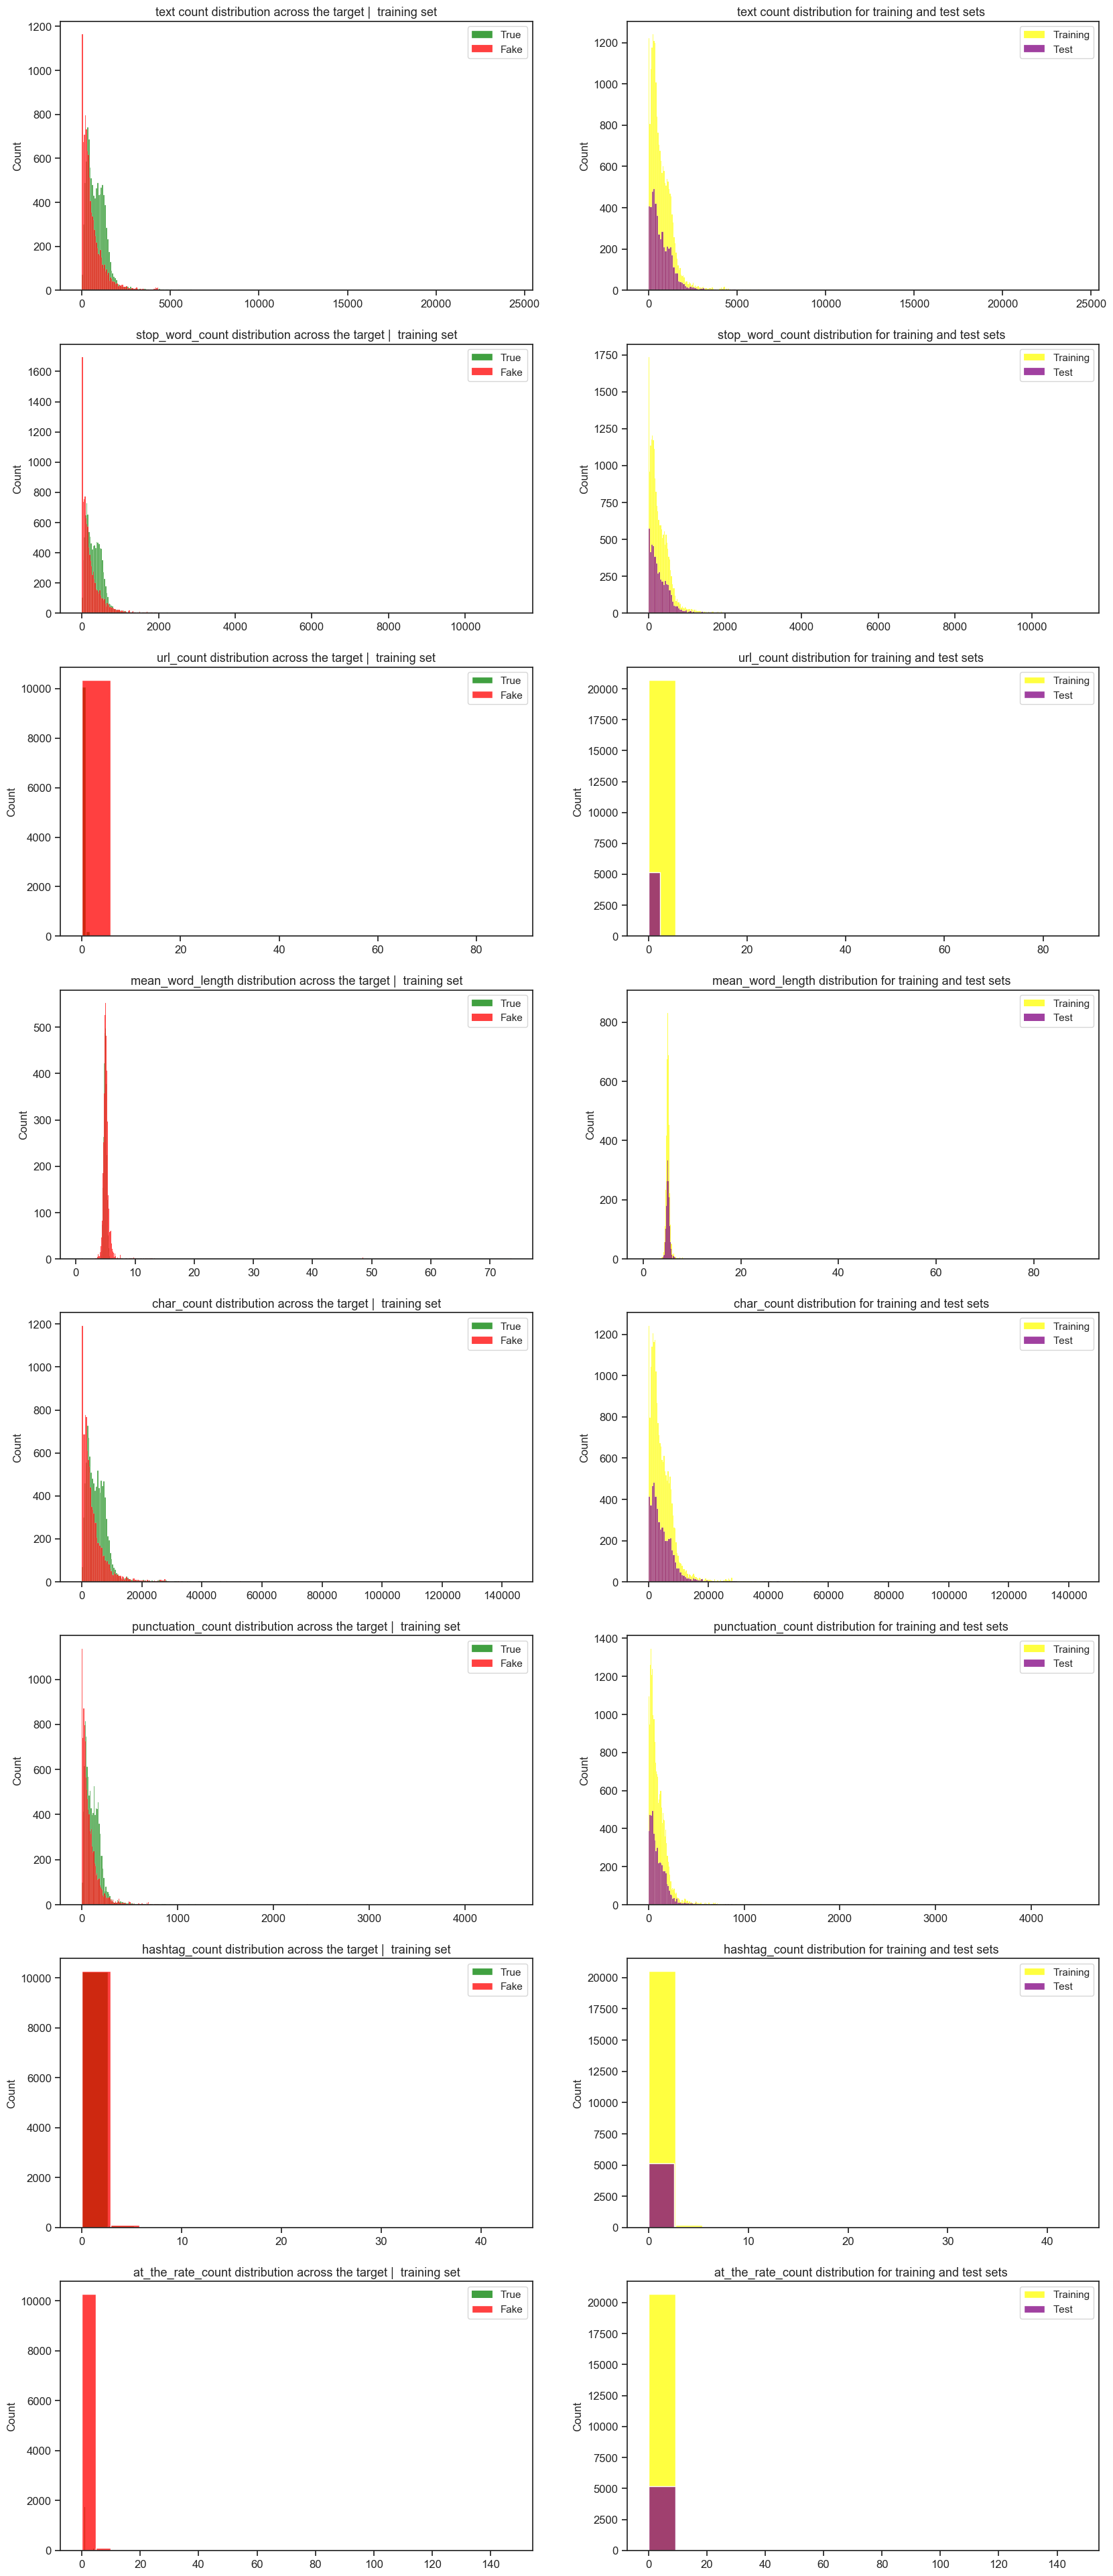

In [56]:
# Inspired by https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
metafeatures = [ 'text count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'at_the_rate_count']

fakenews = train_df['label'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(metafeatures), figsize=(20, 50), dpi=100)

for i, feature in enumerate(metafeatures):
    sns.histplot(train_df.loc[~fakenews][feature], label='True', ax=axes[i][0], color='green')
    sns.histplot(train_df.loc[fakenews][feature], label='Fake', ax=axes[i][0], color='red')

    sns.histplot(train_df[feature], label='Training', ax=axes[i][1], color='yellow')
    sns.histplot(test_df[feature], label='Test', ax=axes[i][1], color = 'purple')
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} distribution across the target |  training set', fontsize=13)
    axes[i][1].set_title(f'{feature} distribution for training and test sets ', fontsize=13)

plt.show()

## Pre-processing the data

In [20]:
# Let us first remove the stop words
stop_words = stopwords.words('english')

In [21]:
def preprocess_text(text):
    # Converting to lower case
    text.lower()
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Tokenizing the corpus
    text_tokens = word_tokenize(text)
    # Remove stopwords
    filtered_words = [w for w in text_tokens if not w in stop_words]
    # Stemming the corpus
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    return " ".join(stemmed_words)

## Word Clouds
* Visualing the most common words arising out of the entire dataset (train and test)
    - A lot of trump and clinton !
    

In [22]:
concat = [train_df, test_df]
concat_df = pd.concat(concat)

In [23]:
processed_text = concat_df['text'].apply(preprocess_text)

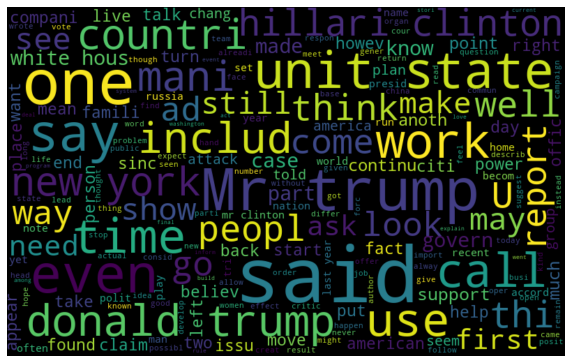

In [24]:
top_words = ' '.join([text for text in processed_text])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(top_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()